In [1]:
%load_ext autoreload
%autoreload 2

from glob import glob
from astropy.time import Time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats

import numpy as np
import pandas as pd
import seaborn as sns

from photutils import RectangularAperture, RectangularAnnulus, aperture_photometry

from matplotlib import pyplot as plt
%matplotlib inline

from pocs.utils import images
from pocs.utils.jupyter import widgets
from piaa import utils

#  Get Data

PIAA is run against an `observation`, which consists of a sequence of `images` for a given `field`. The `field`s are chosen by the PANOPTES network based on their stellar density, targets of interest, and sky coverage, amongst other factors. The default exposure time for each `image` is 120 seconds (regardlesss of conditions such as moon phase) and each `observation` consists of a minimum of two (2) hours of data, giving a total of at least 60 `image`s per `observation`. _(Note: The scheduler can choose to dwell on a field longer than the minimum amount of time, the details of which are not covered here.)_

Here we select an `observation` of the field containing the star `KIC 8462852` (Tabby's star) taken on 2016-09-11 from `PAN001` on Mauna Loa. This particular `observation` was taken before the scheduler details were refined so only consists of 46 total exposures intead of 60.

In [2]:
field_dir = '/var/panoptes/images/fields/Kic8462852/14d3bd/20161108T053950/'
seq_files = glob("{}/2016*.fits".format(field_dir))
seq_files.sort()
print("Number of images: {}".format(len(seq_files)))

Number of images: 43


##### Point Sources

PANOPTES will define a catalog of stars of particular interest, with each entry in the catalog being referred to as a PANOPTES Input Catalog (PIC) star. Each PIC will be identified by a reference id and the catalog will also contain the J2000 RA/Dec of the PIC. These coordinates will be in used with a plate-solved world coordinate system (WCS) to identify the PIC within each `image` of the `observation`.

Because the PICs have not yet formally been defined by PANOPTES, here we use `sextractor` on the first image in the `observation` to identify point sources. This list is not comprehensive and should not be considered representative of the eventual point sources that will be used by PANOPTES.

No refinement of the `sextractor` parameters has been given, with all point sources not flagged by `sextractor` being used for the analysis in the rest of this document.

In [3]:
point_sources = utils.get_point_sources(field_dir, seq_files)
print("Number of point sources: {}".format(len(point_sources)))

Number of point sources: 27913


# Identify Reference PSFs

Reference PSFs are identifed via their morphological similarity with the target PSF across the entire `observation` according to the following process:

1. Flux normalized postage stamp cubes (PSC) are created for each point source, where the `x` and `y` of the cube correspond to the stamp size (see below) and the `z` component corresponds to the individual `image`s.
2. The sum-squared-difference (SSD) of the target stamp and a point source stamp is computed for each `image`.
3. The SSDs are summed across all `image`s in the `observation`, giving a variance ($V$) value that identifies the similarity of the target with a particular point source.
4. Steps 2-3 are repeated for all possible point sources.
5. The point source stamps that have the lowest total variance are then referred to as the `reference` stamps.

Formally, steps 2 and 3 above are defined as:

$$ 
V_{(x_r,y_r)} = \sum_{i=0}^{n-1}
    {\big[ 
        \sum_{u=-w}^{w}{ 
            \big[
            \sum_{v=-w}^{w}{
            \big( 
                B_i(x_t + u, y_t + v) - B_i(x_r + u, y_r + v)
            \big)^2 
            \big]
        }}
    \big]} 
$$

$$(1)$$
where:
* $B$ is the set of images within an `observation`
* $i$ is the image index within set $B$
* $n$ is the number of images in set $B$
* $u$ is the horizontal pixel offset
* $v$ is the vertical pixel offset
* $w$ denotes half the postage stamp width (assuming square stamp)
* $(x_t,y_t)$ is the location of the star within the target postage stamp
* $(x_r,y_r)$ is the location of the star within the reference postage stamp, and
* $B_i(x + u,y + v)$ is the pixel value for pixel $(x + u,y + v)$ in postage stamp $i$ within group $B$.


_Notes:_
* _A postage stamp cube (PSC) is based on the coordiantes of the first image but large enough to capture drift to last image (the `radius` has `padding` to define a larger stamp size). Equation 1 is defined for a sqaure stamp size but the algorithm can handle any particular width and height of a stamp._

### Get Postage Stamp Cubes (Step 1)

For this particular we manually identify a postage stamp size of 40x10, which is enough to capture the drift across all images with at least a 2-pixel padding available around the point source in both the first and last image.

In [4]:
# Make a data cube for the entire observation (and get timing)

start = Time.now()

# padding = (4, 10, 36, 0)
normal_cube = utils.get_cube(seq_files, point_sources, radius=5, normalize=False)

print("Processing time: {:.02f}".format(((Time.now() - start).sec * u.second)))

0..........10..........20..........30..........40...Processing time: 1977.38 s


In [5]:
normal_cube.shape

(27913, 43, 100)

##### Target of Interest identification

For this document we are doing a comparison to a particular target of interest (KIC 8462852 - Tabby's Star), identified below along with other point sources surrounding the target. The results displayed are from the `sextractor` output. In the full PIAA processing, all point sources act as targets of interest such that the steps below are repeated for all possible targets.

In [6]:
# Get the coordinates for the particular 
target = SkyCoord.from_name('Kic8462852')

# Target of interest (manual lookup)
ps = point_sources.to_pandas()
ps[
    (ps['ALPHA_J2000'] >= target.ra.value - 0.1) & (ps['ALPHA_J2000'] <= target.ra.value + 0.1) & 
    (ps['DELTA_J2000'] <= target.dec.value + 0.1) & (ps['DELTA_J2000'] >= target.dec.value - 0.1)]

,MAG_BEST,X,Y,ALPHA_J2000,DELTA_J2000
17735,-7.4415,2262.7693,2065.0227,301.503528,44.491174
17816,-8.5662,2242.5229,2071.8047,301.530026,44.433069
17850,-9.0741,2233.3979,2073.3005,301.535698,44.406918
17896,-8.2875,2250.5261,2079.8438,301.562542,44.455770
17928,-7.1408,2271.2026,2085.9175,301.587682,44.514784
17972,-8.5361,2251.9905,2088.3586,301.596740,44.459737
18119,-8.7407,2249.9963,2101.0164,301.647412,44.453678


#### Get Variance (Step 2-3)

We use our target star as a comparison and compare it to all other point sources in the image.

In [7]:
full_cube = normal_cube.copy()

In [97]:
# Get the variance of the target with each point source and add it to the point source table

start = Time.now()

# Get the variance
target_index = 17896 # See table above
ps['V'] = pd.Series(utils.get_all_variance(normal_cube, target_index, normalize=True))

# Sort the values by lowest total variance
ps.sort_values(by=['V'], inplace=True)

# Save values to file
ps.to_csv('vary_kic8462852_{}.csv'.format(target_index))
    
print("Processing time: {:02f}".format(((Time.now() - start).value * u.second)))

Processing time: 0.000015 s


##### Display Variances

In [98]:
# Display the top five matches
ps[0:5]

,MAG_BEST,X,Y,ALPHA_J2000,DELTA_J2000,V
17896,-8.2875,2250.5261,2079.8438,301.562542,44.455770,0.000000
17676,-8.9167,1898.4940,2051.8433,301.439469,43.449368,1.994443
15631,-9.9713,2568.4910,1823.8293,300.531128,45.368050,2.054120
17816,-8.5662,2242.5229,2071.8047,301.530026,44.433069,2.153976
18067,-9.6280,3354.5483,2094.0325,301.665753,47.614703,2.228250


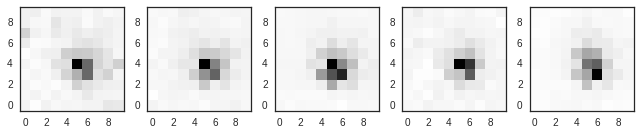

In [99]:
# Best comparisons
utils.compare_psc(normal_cube[ps.index[0:5]], w=10, h=10)

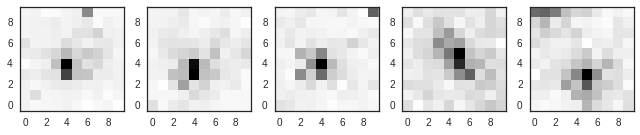

In [100]:
# Worst comparisons
utils.compare_psc(normal_cube[ps.index[-5:]], w=10, h=10)

##### Get aperture photometry

Show the first five frames for the first five best matches. This is a co-moving stamp centered around the particular point source and is used to obtain the photometry for the point source.

In [ ]:
utils.show_aperture_stamps(seq_files, ps)

### RefPSF

Construct an ideal reference PSF from the combination of the reference stamps.

**_NOTE: Under Construction Below._**

Here we are looping through each file and constructing a postage stamp around the point source in order to get the aperture flux for the source and the reference. The postage stamp and aperture corresponds to that displayed above, with a 6-square pixel aperture and a 10-square pixel overall stamp size. 

The stamp is split into individual color channels and for each color channel the background median is obtained via `astropy`'s `sigma_clipped_stats` function.

In [117]:
num_refs = 50
num_frames = 43
frame_num = 0

### Find coefficients

In [118]:
# Get the normalized reference stars
refs = normal_cube[ps[1:(num_refs+1)].index]
refs.shape

(50, 43, 100)

In [152]:
refs.mean(1).shape

(50, 100)

In [165]:
refs[0, 0].reshape(10, 10)

array([[ -3.36360579e-04,  -1.42953246e-02,  -7.39993273e-03,
         -1.09317188e-02,  -6.72721157e-03,  -1.66498486e-02,
         -4.37268752e-03,  -3.53178607e-03,   3.36360579e-03,
         -5.21358897e-03],
       [ -2.37134208e-02,  -4.03632694e-03,  -1.68180289e-04,
         -2.69088463e-03,  -1.29498823e-02,  -2.69088463e-03,
         -1.51362260e-03,  -5.71812984e-03,  -6.22267070e-03,
         -6.05449041e-03],
       [ -5.38176926e-03,  -9.58627649e-03,   1.34544231e-03,
          5.21358897e-03,   7.39993273e-03,   5.97040027e-02,
          8.07265388e-03,   2.67406660e-02,  -6.72721157e-04,
         -7.90447360e-03],
       [ -1.19408005e-02,  -1.00908174e-03,  -5.88631012e-03,
          8.74537504e-03,   5.29767911e-02,   1.11671712e-01,
          1.57584931e-01,   4.27177935e-02,   1.56407669e-02,
          1.68180289e-03],
       [  0.00000000e+00,  -1.26135217e-02,   5.71812984e-03,
          2.20316179e-02,   2.08543559e-02,   2.42347797e-01,
          1.26471578e-01

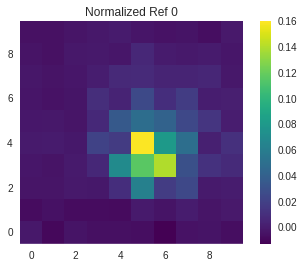

In [119]:
plt.imshow(refs[1, frame_num].reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Normalized Ref {}'.format(frame_num))

In [120]:
# Get normalized target
tar = normal_cube[ps.iloc[0].name]
tar.shape

(43, 100)

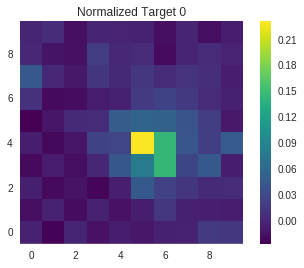

In [121]:
plt.imshow(tar[frame_num].reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Normalized Target {}'.format(frame_num))

In [122]:
a0 = tar[frame_num] / refs[1, frame_num]
a0.shape

(100,)

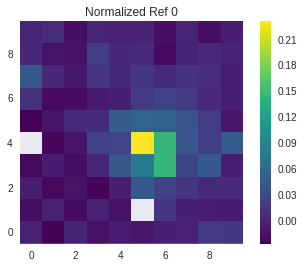

In [123]:
plt.imshow((refs[1, frame_num] * a0).reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Normalized Ref {}'.format(frame_num))

In [108]:
def get_ref_psf(x, B):
    # Build the matrix
    A = np.vstack([x]).T
       
    # Solve the least-squares
    p = np.linalg.lstsq(A, B)[0]
        
    return p

In [69]:
# Find the coefficients that align the reference with the target
coeff = get_ref_psf(refs.reshape(num_refs, num_frames * 100), tar.flatten())
coeff

array([ 0.16810049,  0.19129506,  0.13048446,  0.04544146,  0.00245315,
        0.09140207, -0.00815176,  0.07232751,  0.18248325,  0.00077592,
        0.07898107,  0.13667872,  0.01675405,  0.02201486, -0.13896557,
        0.01334088, -0.00402502,  0.01757142,  0.07445329,  0.02182003,
        0.14515156,  0.08805422, -0.06589638,  0.0824682 , -0.07150244,
        0.04547072,  0.00670601,  0.12528397, -0.01708475, -0.05354384,
       -0.09706572,  0.0582803 ,  0.04987069, -0.08015944,  0.01274389,
        0.04040167,  0.04050855, -0.24400965, -0.15850255,  0.00237558,
       -0.0248213 , -0.08014069,  0.17412783, -0.00883246,  0.07693287,
       -0.05906296,  0.04095394,  0.06445192, -0.04795668, -0.11641181])

### Full Target

In [109]:
# Get the full stamps
# full_cube = utils.get_cube(seq_files[0:num_frames], point_sources, radius=5)

In [124]:
# Full target
tar_t = full_cube[ps.iloc[0].name]
tar_t.shape

(43, 100)

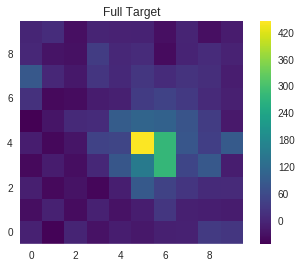

In [125]:
# Show target
sns.set_style('dark')
plt.imshow(tar_t[frame_num].reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Full Target')

### Construct RefPSF

In [126]:
# Get the full reference stars
b = full_cube[ps[1:(num_refs+1)].index] #.reshape(num_refs, num_frames * 100)
b.shape

(50, 43, 100)

In [127]:
refpsf = b[1, frame_num, :] * a0

In [ ]:
# Multiple the references by the coefficients
refpsf = coeff.dot(b).reshape(num_frames,100)

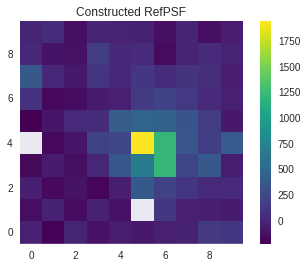

In [128]:
# Show the constructed PSF
sns.set_style('dark')
# plt.imshow(refpsf.reshape(num_frames, 10, 10)[frame_num], cmap='viridis')
# plt.imshow(refpsf[frame_num].reshape(10, 10), cmap='viridis')
plt.imshow(refpsf.reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Constructed RefPSF')

### Show Residuals

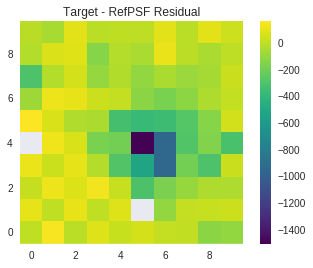

In [129]:
# Get the residuals for inspection
res = tar_t - refpsf

sns.set_style('dark')
plt.imshow(res[frame_num].reshape(10, 10), cmap='viridis')
plt.colorbar()
plt.title('Target - RefPSF Residual')

### RRC

Here we perform the Remove, Replace, and Compare step. Since we want to compare each image to the other images, we consider the set of images $A$ that we are testing to consist of only one image at a time while the set of comparison images are all other frames in the `observation`.

Then an estimate of the transit depth $a_j$ may be obtained for frame $j$ by:

$$
(1+a_j) = 
    \frac{
        \displaystyle{
                \sum_{u=-w}^{w}{ 
                    \sum_{v=-w}^{w}{
                        A_j(x_t + u, y_t + v)
                }}
        } 
    }{
        \displaystyle{
                \sum_{u=-w}^{w}{ 
                    \sum_{v=-w}^{w}{
                        \mathrm{RefPSF}_j(u, v)
                }}
        } 
    }
$$

$$(3)$$

This equation may be improved by optimal weighting of pixel values.

In [80]:
a = tar_t / refpsf

In [81]:
curve = [a[i].sum() / 100 for i in range(len(a))]

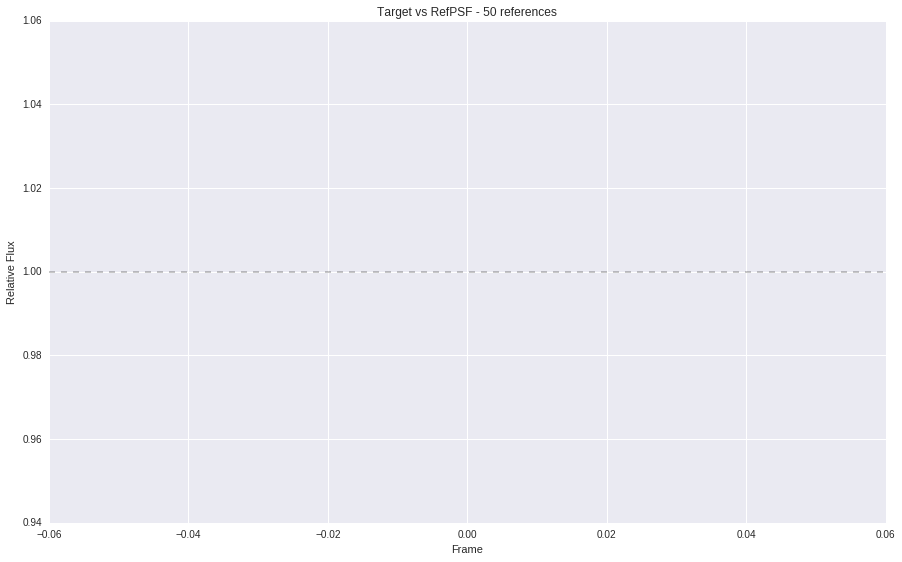

In [83]:
sns.set_style('darkgrid')
plt.figure(figsize=(15, 9))
plt.plot(curve)
plt.ylabel('Relative Flux')
plt.xlabel('Frame')
plt.title('Target vs RefPSF - {} references'.format(num_refs))
# plt.ylim(.95, 1.05)
plt.axhline(1.0, ls='--', c='k', alpha=0.25)